In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at 
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to 

In [3]:
release14_hc_meta_mt_uri =   "SG10K-SV-Release-1.4-HighConfidenceSV-WithMetadata-correctrsid.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(release14_hc_meta_mt_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [5]:
import pandas as pd

_mt = (mt
        .group_rows_by(mt.callers_info.SVTYPE)
        .aggregate(
            sv_count = hl.agg.count_where(mt.GT.is_hom_var()) + hl.agg.count_where(mt.GT.is_het())
        )
      )

df = (_mt
      .annotate_cols(ethnicity = _mt.metadata.Self_Reported_Ethnicity)
      .rename({"SVTYPE": "sv_type"})
      .drop('metadata')
      .entries()
      .to_pandas()
     )
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
0         DEL  WHB1000   Chinese      1374
1         DEL  WHB1001   Chinese      1554
2         DEL  WHB1002   Chinese      1405
3         DEL  WHB1003    Indian      1453
4         DEL  WHB1004   Chinese      1420
...       ...      ...       ...       ...
16456     INS  WHH7169    Indian      1452
16457     INS  WHH7170   Chinese      1381
16458     INS  WHH7172   Chinese      1274
16459     INS  WHH7173   Chinese      1314
16460     INS  WHH7174   Chinese      1316

[16461 rows x 4 columns]
2024-05-24 10:38:35 Hail: WARN: entries(): Resulting entries table is sorted by '(row_key, col_key)'.
    To preserve row-major matrix table order, first unkey columns with 'key_cols_by()'
2024-05-24 10:39:27 Hail: INFO: Coerced sorted dataset
2024-05-24 10:39:27 Hail: INFO: Coerced dataset with out-of-order partitions.

In [6]:
# extract deletions
del_df = df[df['sv_type'] == "DEL"]
del_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB1000   Chinese      1374
1        DEL  WHB1001   Chinese      1554
2        DEL  WHB1002   Chinese      1405
3        DEL  WHB1003    Indian      1453
4        DEL  WHB1004   Chinese      1420
...      ...      ...       ...       ...
5482     DEL  WHH7169    Indian      1670
5483     DEL  WHH7170   Chinese      1347
5484     DEL  WHH7172   Chinese      1165
5485     DEL  WHH7173   Chinese      1277
5486     DEL  WHH7174   Chinese      1117

[5487 rows x 4 columns]

In [7]:
del_ethnic = del_df[del_df.ethnicity != "Others"]
del_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB1000   Chinese      1374
1        DEL  WHB1001   Chinese      1554
2        DEL  WHB1002   Chinese      1405
3        DEL  WHB1003    Indian      1453
4        DEL  WHB1004   Chinese      1420
...      ...      ...       ...       ...
5482     DEL  WHH7169    Indian      1670
5483     DEL  WHH7170   Chinese      1347
5484     DEL  WHH7172   Chinese      1165
5485     DEL  WHH7173   Chinese      1277
5486     DEL  WHH7174   Chinese      1117

[5469 rows x 4 columns]

In [8]:
del_all = del_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
del_all['ethnicity'] = 'All'
del_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB1000       All      1374
1        DEL  WHB1001       All      1554
2        DEL  WHB1002       All      1405
3        DEL  WHB1003       All      1453
4        DEL  WHB1004       All      1420
...      ...      ...       ...       ...
5482     DEL  WHH7169       All      1670
5483     DEL  WHH7170       All      1347
5484     DEL  WHH7172       All      1165
5485     DEL  WHH7173       All      1277
5486     DEL  WHH7174       All      1117

[5469 rows x 4 columns]

In [9]:
frames = [del_ethnic, del_all]
del_table = pd.concat(frames)
del_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHB1000   Chinese      1374
1        DEL  WHB1001   Chinese      1554
2        DEL  WHB1002   Chinese      1405
3        DEL  WHB1003    Indian      1453
4        DEL  WHB1004   Chinese      1420
...      ...      ...       ...       ...
5482     DEL  WHH7169       All      1670
5483     DEL  WHH7170       All      1347
5484     DEL  WHH7172       All      1165
5485     DEL  WHH7173       All      1277
5486     DEL  WHH7174       All      1117

[10938 rows x 4 columns]

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style='white')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=del_table,
                    palette = ['#D62628','#2EA02B', '#9467BD', '#A9A9A9'])
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = del_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        1584.964527
Chinese    1594.561528
Indian     1551.240097
Malay      1595.525350
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

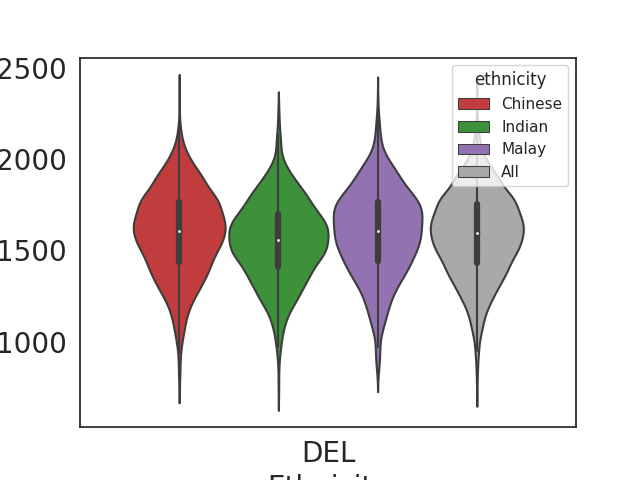

In [11]:
%matplot plt

In [12]:
%%sh
pip install boto3

In [13]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=del_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'],
                      linewidth=2
)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

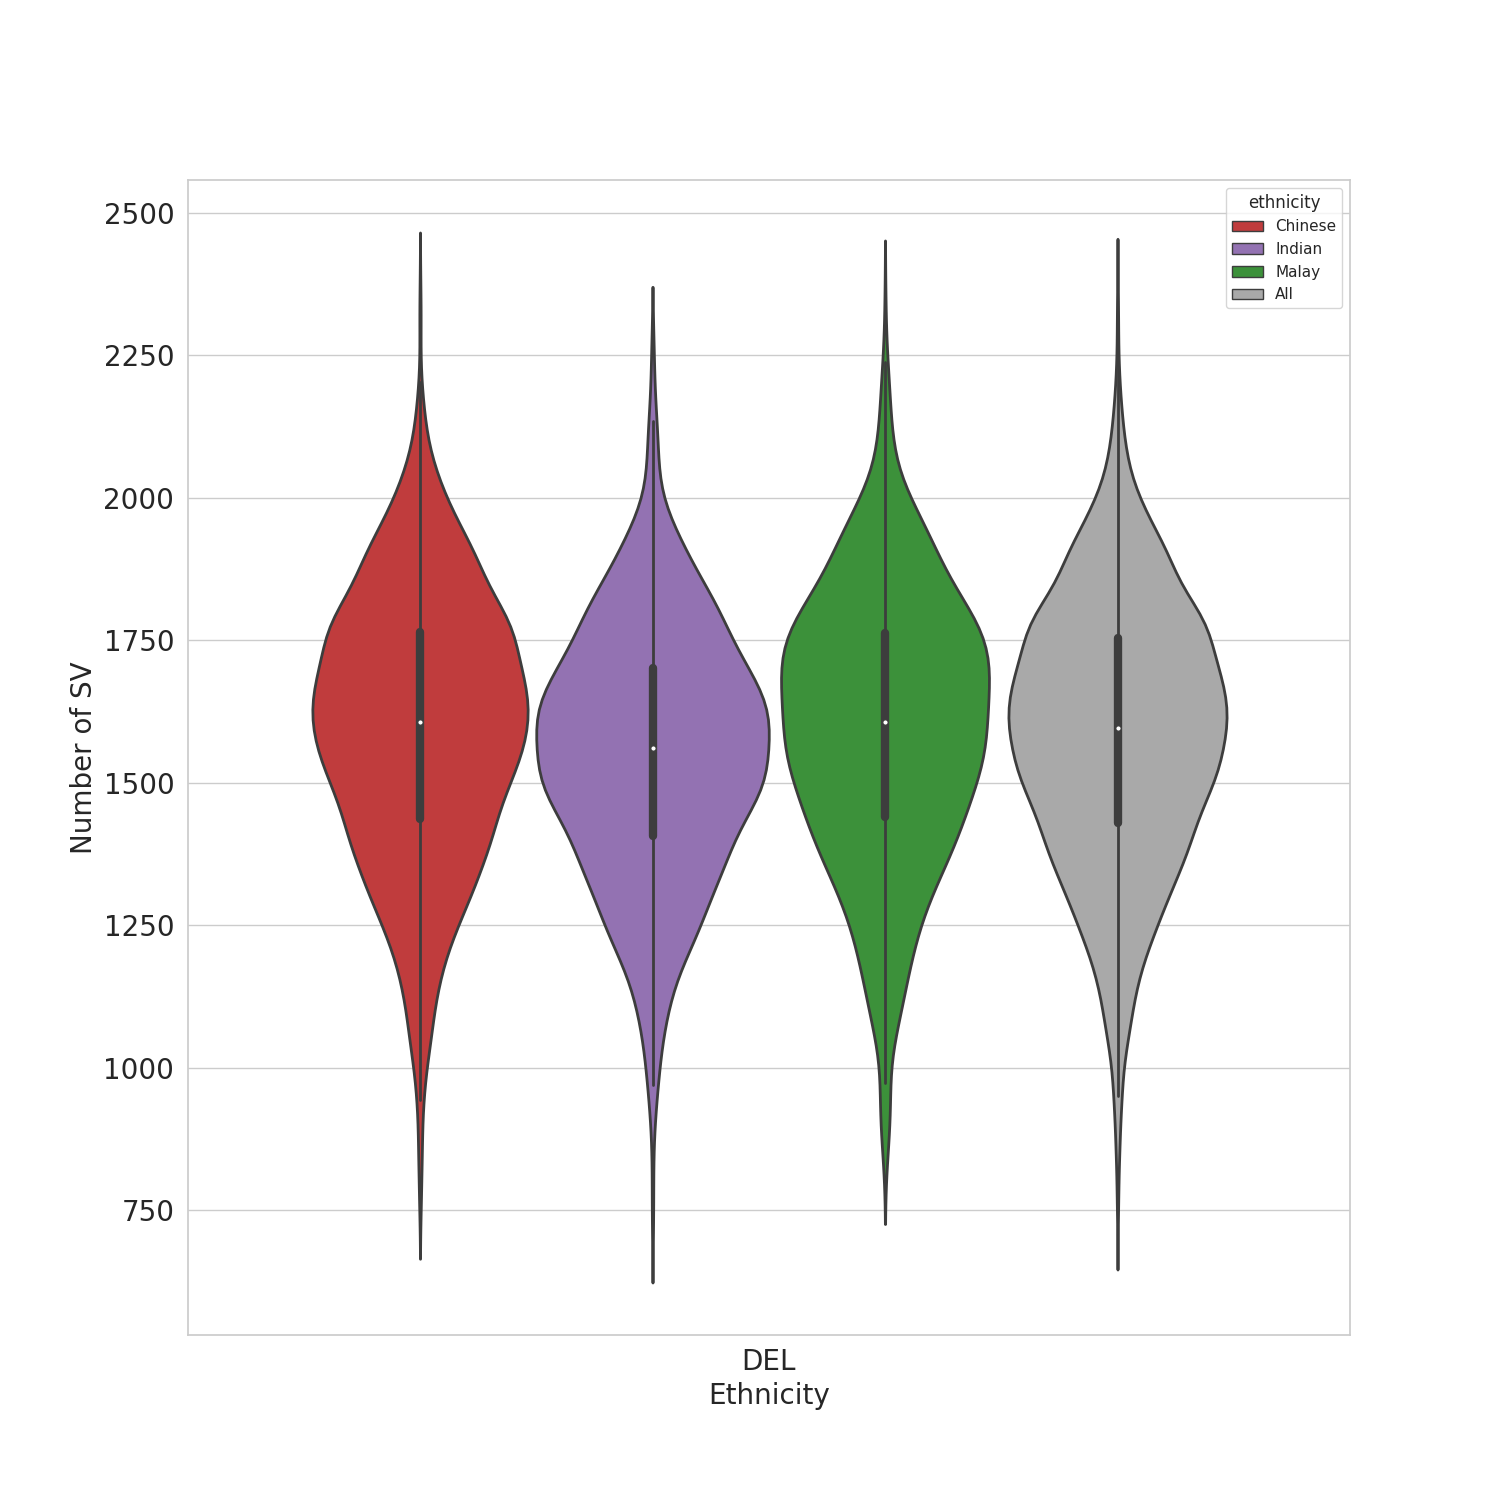

In [64]:
%matplot plt

In [65]:
save_fig_to_s3(plt, "Figures", "Figure2/Fig2a_Numberofdeletionsperethnicgroup_whitegrid_correctcolour_fatterboxplot.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Insertions

In [25]:
# extract insertions
ins_df = df[df['sv_type'] == "INS"]
ins_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
10974     INS  WHB1000   Chinese      1411
10975     INS  WHB1001   Chinese      1404
10976     INS  WHB1002   Chinese      1326
10977     INS  WHB1003    Indian      1449
10978     INS  WHB1004   Chinese      1448
...       ...      ...       ...       ...
16456     INS  WHH7169    Indian      1452
16457     INS  WHH7170   Chinese      1381
16458     INS  WHH7172   Chinese      1274
16459     INS  WHH7173   Chinese      1314
16460     INS  WHH7174   Chinese      1316

[5487 rows x 4 columns]

In [26]:
ins_ethnic = ins_df[ins_df.ethnicity != "Others"]
ins_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
10974     INS  WHB1000   Chinese      1411
10975     INS  WHB1001   Chinese      1404
10976     INS  WHB1002   Chinese      1326
10977     INS  WHB1003    Indian      1449
10978     INS  WHB1004   Chinese      1448
...       ...      ...       ...       ...
16456     INS  WHH7169    Indian      1452
16457     INS  WHH7170   Chinese      1381
16458     INS  WHH7172   Chinese      1274
16459     INS  WHH7173   Chinese      1314
16460     INS  WHH7174   Chinese      1316

[5469 rows x 4 columns]

In [27]:
ins_all = ins_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
ins_all['ethnicity'] = 'All'
ins_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
10974     INS  WHB1000       All      1411
10975     INS  WHB1001       All      1404
10976     INS  WHB1002       All      1326
10977     INS  WHB1003       All      1449
10978     INS  WHB1004       All      1448
...       ...      ...       ...       ...
16456     INS  WHH7169       All      1452
16457     INS  WHH7170       All      1381
16458     INS  WHH7172       All      1274
16459     INS  WHH7173       All      1314
16460     INS  WHH7174       All      1316

[5469 rows x 4 columns]

In [28]:
frames_ins = [ins_ethnic, ins_all]
ins_table = pd.concat(frames_ins)
ins_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
10974     INS  WHB1000   Chinese      1411
10975     INS  WHB1001   Chinese      1404
10976     INS  WHB1002   Chinese      1326
10977     INS  WHB1003    Indian      1449
10978     INS  WHB1004   Chinese      1448
...       ...      ...       ...       ...
16456     INS  WHH7169       All      1452
16457     INS  WHH7170       All      1381
16458     INS  WHH7172       All      1274
16459     INS  WHH7173       All      1314
16460     INS  WHH7174       All      1316

[10938 rows x 4 columns]

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=ins_table,
                    palette = ['#D62628', '#9467BD', '#2EA02B','#A9A9A9'],linewidth=2)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = ins_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        1439.483635
Chinese    1432.237370
Indian     1451.252223
Malay      1446.318182
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

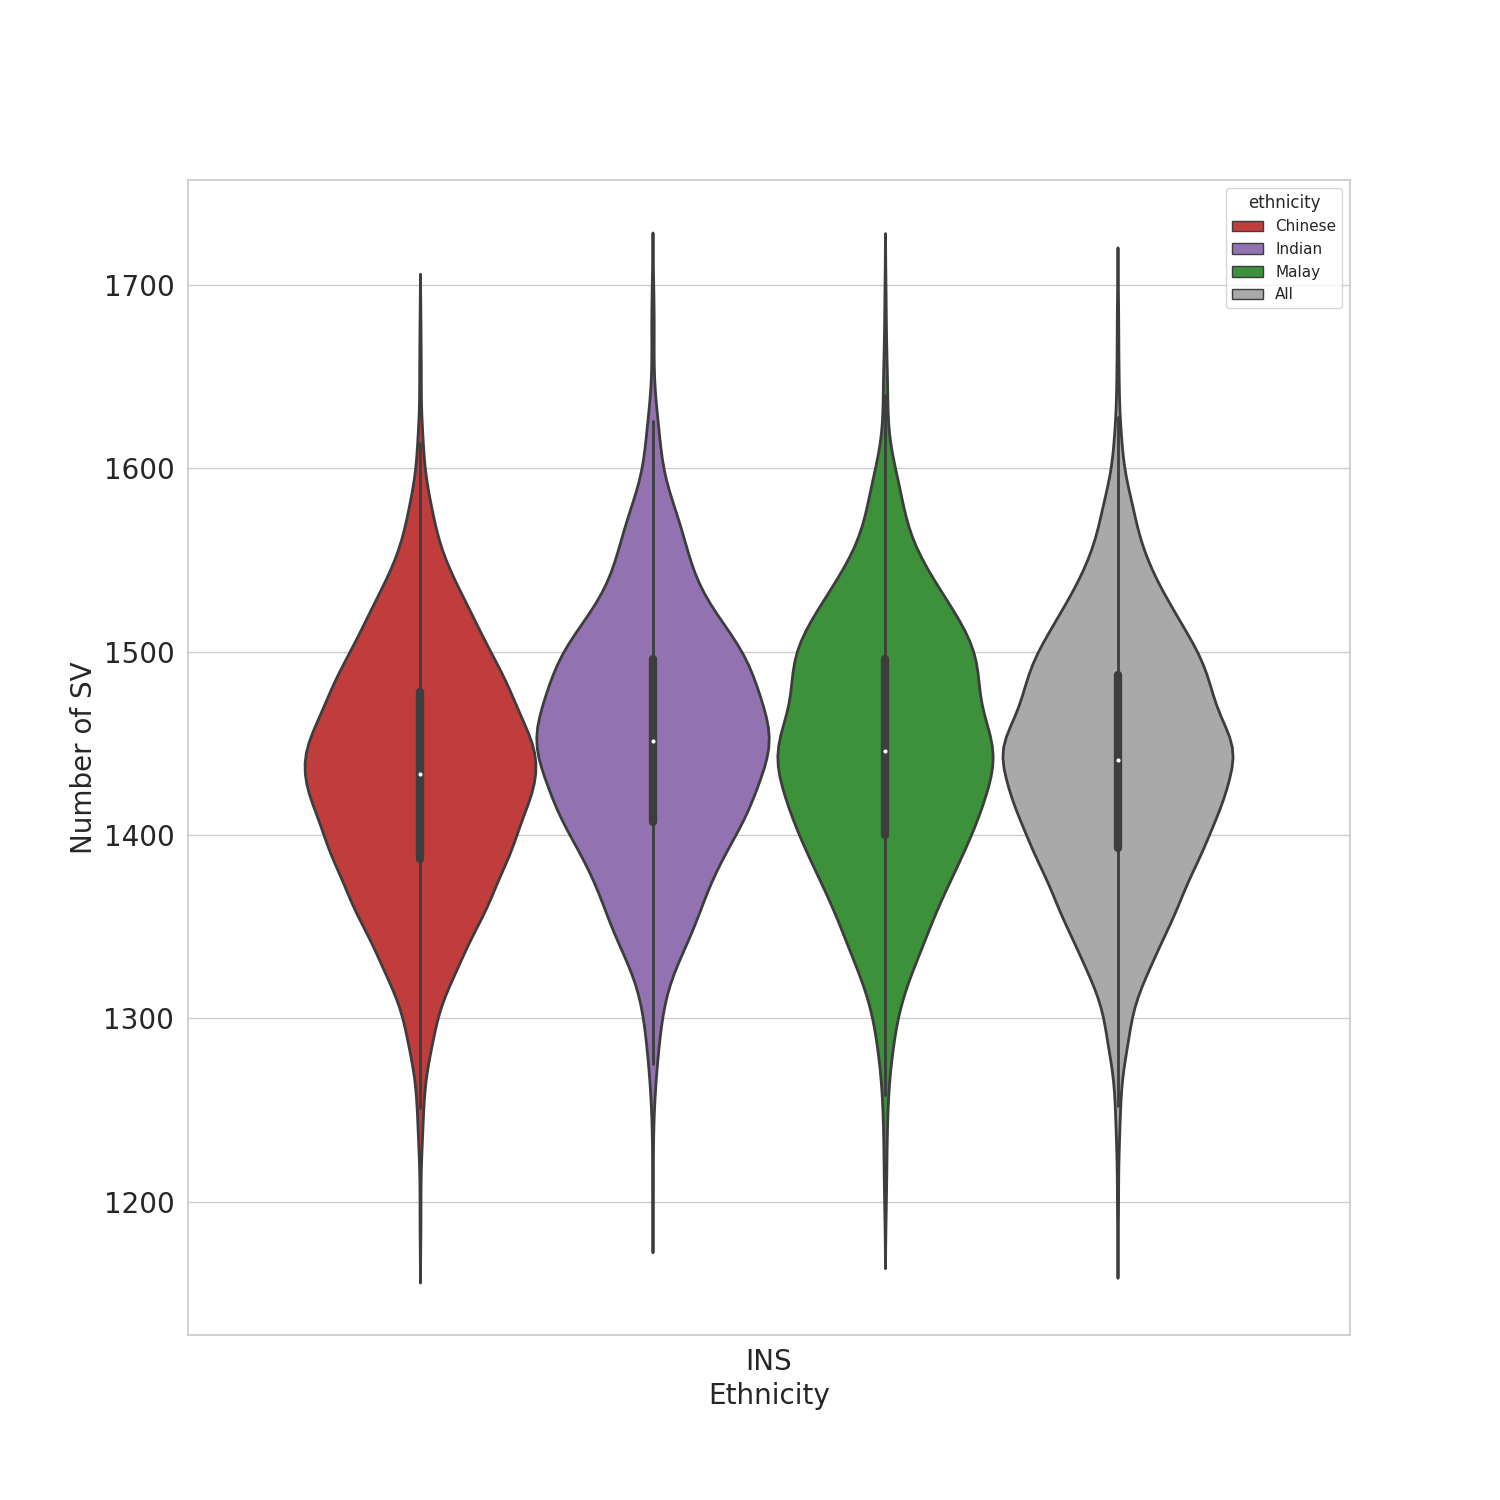

In [70]:
%matplot plt

In [71]:
save_fig_to_s3(plt, "Figures", "Figure2/Fig2a_NumberofInsertionsperethnicgroup_whitegrid_correctcolour_fatterboxplot.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Duplications

In [32]:
# extract duplications
dup_df = df[df['sv_type'] == "DUP"]
dup_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
5487      DUP  WHB1000   Chinese       889
5488      DUP  WHB1001   Chinese       988
5489      DUP  WHB1002   Chinese       839
5490      DUP  WHB1003    Indian       912
5491      DUP  WHB1004   Chinese       799
...       ...      ...       ...       ...
10969     DUP  WHH7169    Indian      1412
10970     DUP  WHH7170   Chinese       913
10971     DUP  WHH7172   Chinese       844
10972     DUP  WHH7173   Chinese       698
10973     DUP  WHH7174   Chinese       819

[5487 rows x 4 columns]

In [33]:
dup_ethnic = dup_df[dup_df.ethnicity != "Others"]
dup_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
5487      DUP  WHB1000   Chinese       889
5488      DUP  WHB1001   Chinese       988
5489      DUP  WHB1002   Chinese       839
5490      DUP  WHB1003    Indian       912
5491      DUP  WHB1004   Chinese       799
...       ...      ...       ...       ...
10969     DUP  WHH7169    Indian      1412
10970     DUP  WHH7170   Chinese       913
10971     DUP  WHH7172   Chinese       844
10972     DUP  WHH7173   Chinese       698
10973     DUP  WHH7174   Chinese       819

[5469 rows x 4 columns]

In [34]:
dup_all = dup_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
dup_all['ethnicity'] = 'All'
dup_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
5487      DUP  WHB1000       All       889
5488      DUP  WHB1001       All       988
5489      DUP  WHB1002       All       839
5490      DUP  WHB1003       All       912
5491      DUP  WHB1004       All       799
...       ...      ...       ...       ...
10969     DUP  WHH7169       All      1412
10970     DUP  WHH7170       All       913
10971     DUP  WHH7172       All       844
10972     DUP  WHH7173       All       698
10973     DUP  WHH7174       All       819

[5469 rows x 4 columns]

In [35]:
frames_dup = [dup_ethnic, dup_all]
dup_table = pd.concat(frames_dup)
dup_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      sv_type        s ethnicity  sv_count
5487      DUP  WHB1000   Chinese       889
5488      DUP  WHB1001   Chinese       988
5489      DUP  WHB1002   Chinese       839
5490      DUP  WHB1003    Indian       912
5491      DUP  WHB1004   Chinese       799
...       ...      ...       ...       ...
10969     DUP  WHH7169       All      1412
10970     DUP  WHH7170       All       913
10971     DUP  WHH7172       All       844
10972     DUP  WHH7173       All       698
10973     DUP  WHH7174       All       819

[10938 rows x 4 columns]

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=dup_table,
                    palette = ['#D62628', '#9467BD', '#2EA02B','#A9A9A9'], linewidth=2)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = dup_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        1103.674895
Chinese    1099.661917
Indian     1099.739693
Malay      1118.762238
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

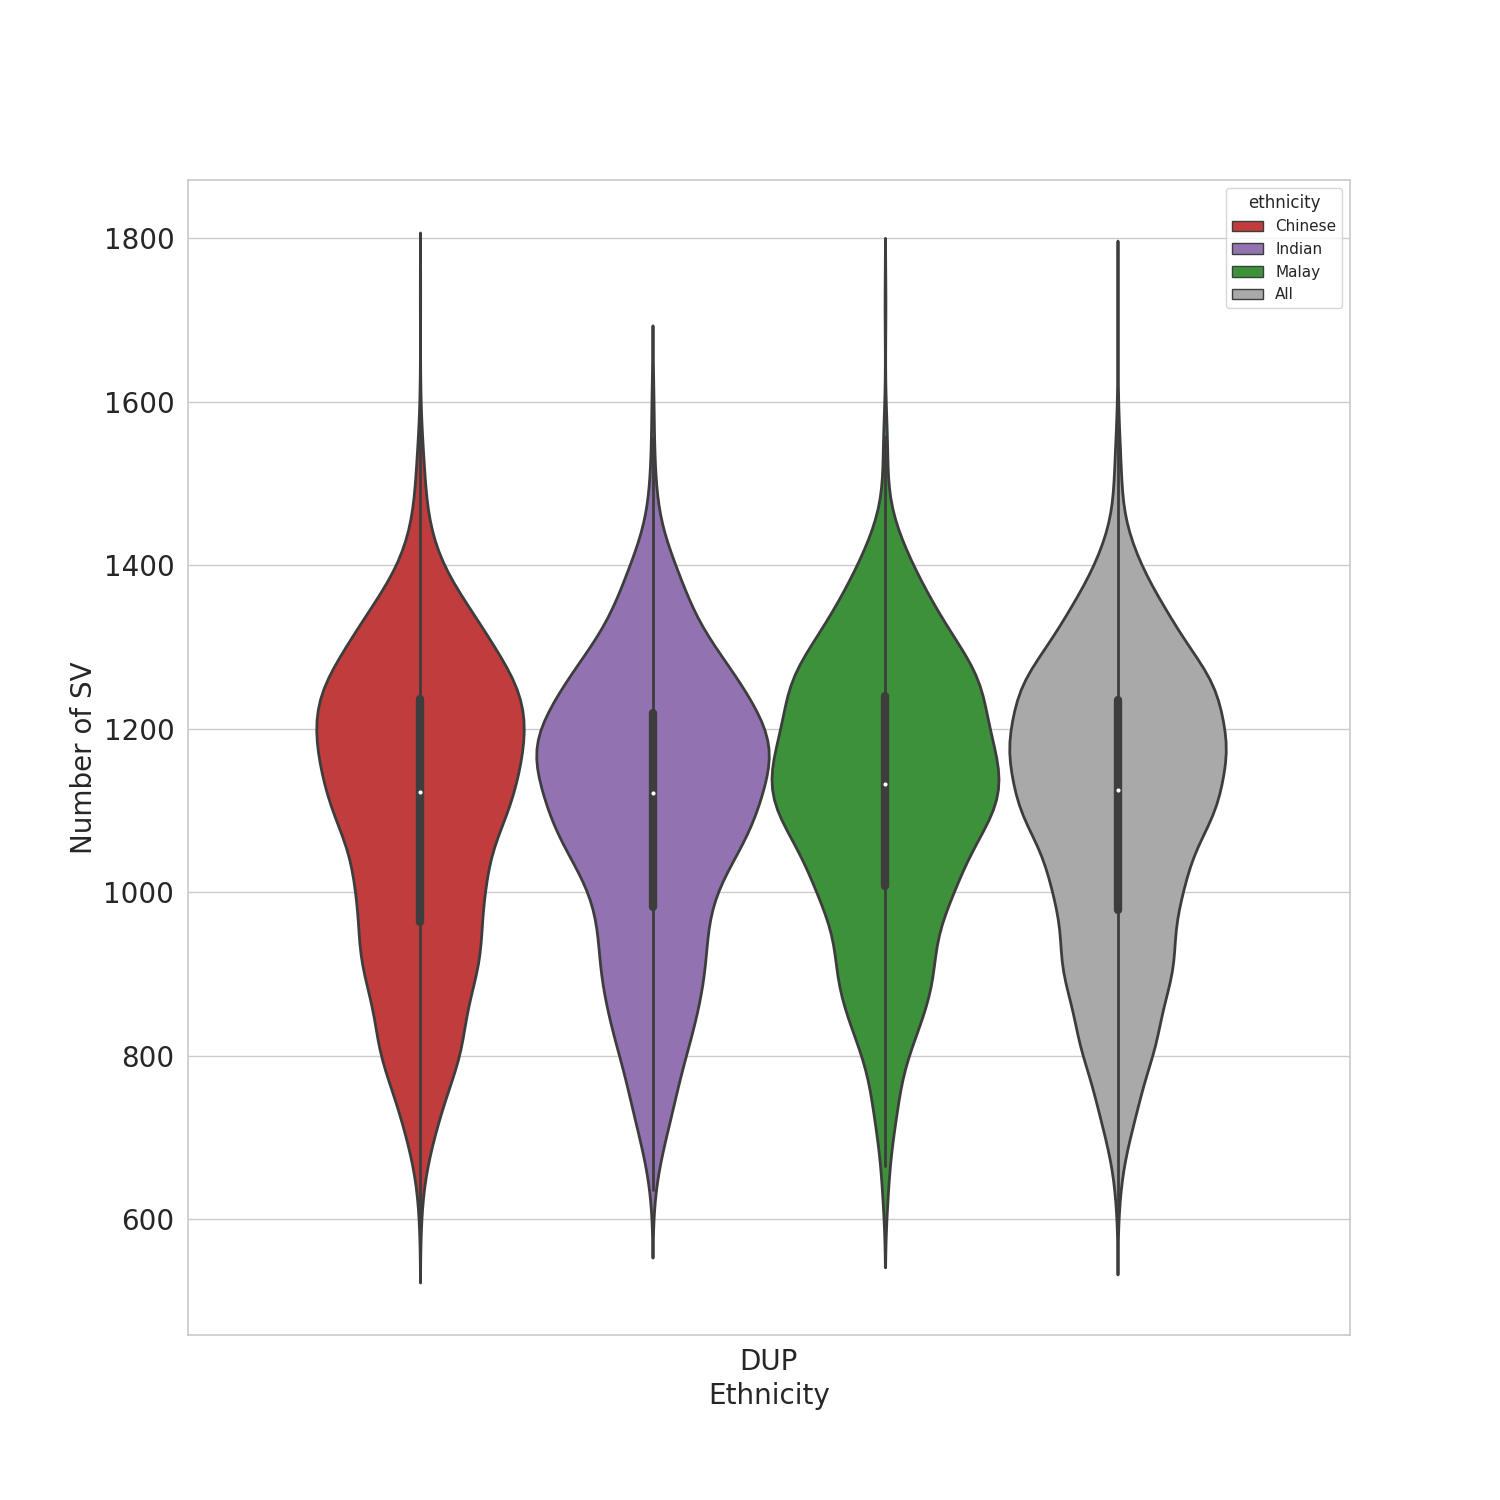

In [73]:
%matplot plt

In [74]:
save_fig_to_s3(plt, "Figures", "Figure2/Fig2a_NumberofDuplicationsperethnicgroup_whitegrid_correctcolour_fatterboxplot.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…